링크 주소: tinyurl.com/skt-04-12
다운로드 후 google drive 업로드
Colaboratory로 열기.

### pyTorch 를 비롯해 오늘 실습에 필요한 파이썬 라이브러리를 읽어들입니다.

In [0]:
import torch
import torch.nn as nn #
import torch.nn.functional as F #
import torchvision # 이미지 관련 처리, Pretrained Model 관련된 Package 입니다. 
import torchvision.datasets as vision_dsets
import torchvision.transforms as transforms # 이미지 처리 (Vison) 관련된 transformation이 정의 되어 있습니다. ... data load 할 때 쓰는 것
import torch.optim as optim # pytorch 에서 정의한 수 많은 optimization function 들이 들어 있습니다. ... Gradient optimizer 할때
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt # 시각화를 위한 패키지입니다.

### Hyper-parameter 세팅 및 기타 변수 지정

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # pytorch0.4.0 이상 버젼에서 gpu 설정하는 방식, tensor.to(device) 이런식으로 사용
lr = 0.001
batch_size = 128
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

### 다양한 함수 연습

In [4]:
# torch.view 연습

sample = torch.randn(2000,3,64,64) #.to(device) 하면 gpu로 넘어가는 것!
##이건 normal에서 뽑겠다! 2000 : batch 3: channel 64: height 64 : width

#기본적으로, 이미지 처리를 할때 파이토치의 텐서 구성은 Batch, Channel, Height, Width로 구성.
#코딩 시 B,C,H,W로 변수화하여 사용하면 편리

B,C,H,W = sample.size()

# sample => (2000, 64, 64, 3).  
sample_1 = sample.view(B, -1) #위 sample 을 (2000, 3*64*64)으로 바꿔보세요. 
##batch dimension과 element들~

print(sample_1.size())
sample.size()

torch.Size([2000, 12288])


torch.Size([2000, 3, 64, 64])

In [5]:
#위 sample 을 (2000*3, 64*64)로 바꿔보세요.
sample_2 = sample.view(B*C, H*W) ##view란 reshape와 같은 것!!
print(sample_2.size())

torch.Size([6000, 4096])


In [5]:
# torch.view 다른 예제
a = torch.FloatTensor(5,20,100) ## just batch channel height
a1 = a.view(2, 10, -1) ##-1은 나머지를 몰아주기!
print(a1.size())
a2 = a.view(-1,10, 200)
print(a2.size())

torch.Size([2, 10, 500])
torch.Size([5, 10, 200])


In [6]:
# dimension간의 이동을 하고 싶으면? ex) B,C,H,W => B,C,W,H 
sample = torch.randn(2000,3,32,64)
sample_1 = sample.permute(0,1,3,2) ##permute의 경우 2랑 3이랑 자리를 바꾸겠다!
print(sample.size())
print(sample_1.size())

torch.Size([2000, 3, 32, 64])
torch.Size([2000, 3, 64, 32])


In [7]:
# sample_1 변수의 디멘션을 다시 원래대로 돌리려면?
sample_2 = sample_1.permute(0,1,3,2)
print(torch.equal(sample,sample_2))

True


### Convolution layer  가지고 놀기 

In [0]:
# torch.nn.conv 연습
# 클래스 구성: nn.Conv2d(in, out, filter_size, stride, padding)
# 아웃풋사이즈가 이와같이 되도록 되도록 해봅니다: (16, 128, 32, 32)
input1 = torch.zeros(16, 3, 64, 64) ## B C H W
conv1 = nn.Conv2d(3, 512, 3, 1, 1) ##input_ch output_ch, filter, stride , padding
## 16 ,3, 64, 64 => 16, 512, 64, 64 ... if filter -> 5? -> padding 2 이런식으로 하면 spatial이 유지가 된다!
conv2 = nn.Conv2d(512,128,4,2,1)
## 16, 512, 64, 64 => 16, 128, 32, 32 ...stride를 늘리게 되면 spatial이 반토막이 나버린다.

out = conv1(input1)
output = conv2(out)

print(output.size())

torch.Size([16, 128, 32, 32])


In [0]:
# torch.nn.conv 연습
# 클래스 구성: nn.Conv2d(in, out, filter_size, stride, padding)
# 아웃풋사이즈가 이와같이 되도록 해봅니다: (16, 512, 16, 16)
input = torch.zeros(16, 3, 64, 64) 
conv1 = nn.Conv2d(3,64,3,1,1) ## 16, 3, 64, 64 => 16, 64, 64, 64
conv2 = nn.Conv2d(64,512,3,4,1) ##16, 64, 64, 64 => 16, 512, (64/4), (64/4)

##stride가 4인거는 네트워크에서 사용하지 않는다!! 그러나 이동하게 되면 2^2만큼 줄어들게 된다.

out = conv1(input)
output = conv2(out)

print(output.size())

torch.Size([16, 512, 16, 16])


In [0]:
#quiz 4 (torch.nn.conv 연습)
# 클래스 구성: nn.Conv2d(in, out, filter_size, stride, padding)
# 아웃풋사이즈가 이와같이 되도록 해봅니다: (16, 512, 64, 64)
input = torch.zeros(16, 3, 64, 64)
conv1 = nn.Conv2d(3,64,3,1,1) 
conv2 = nn.Conv2d(64,512,3,1,1)

out = conv1(input)
output = conv2(out)

print(output.size()) ##이 아이는 stride를 건드리지 않아서 그냥 그대로 간다~

torch.Size([16, 512, 64, 64])


### 데이터 로딩

Data Augmentation?

In [6]:
# Data
print('==> Preparing data..')
# 데이터 전처리를 위한 코드
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 4만큼의 padding을 부여한 후, 32x32로 random cropping
    ##이미지가 있으면, 랜덤하게 자르는 것!
    transforms.RandomHorizontalFlip(), # 0.5의 확률로 이미지 좌우 반전하여 넣어줌
    ## 위에 있던 것을 좌우를 바꿔버린다.
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
    ## 우리가 사용하는 학습데이터의 mu와 시그마를 구해준다. rgb에 대한 것들!! mean sd
])

# 랜덤 cropping을 하고, 이미지 좌우반전을 해주는 이유 : ???

# 데이터 전처리를 위한 코드
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
    ## 우리가 사용하는 테스트데이터의 mu와 시그마를 구해준다. rgb에 대한 것들!! mean sd
])

# 데이터 로딩
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
## batch_size가 들어갔다! 우리가 가지고 있는 데이터/batch_size 해주면 mini batch의 수가 나오게 된다!!

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


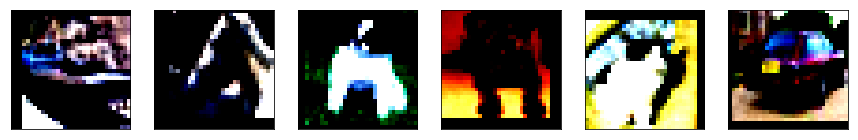

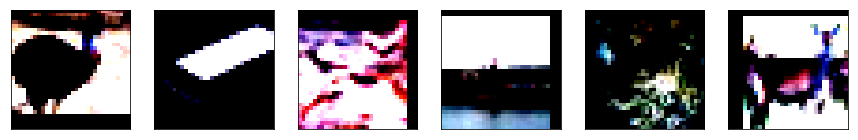

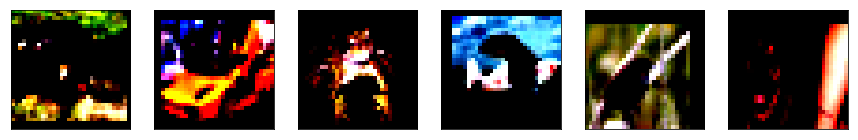

In [7]:
def showImages(image, row):
  
  for _ in range(row):  
  
    idx = np.random.choice(batch_size, 6)     # 0 ~ 127 의 정수 중 6 개를 임의로 선택
    images =image.numpy()[idx].transpose(0,2,3,1).clip(0,1)         # 선택된 index 에 해당하는 이미지를 가져옴
    plt.figure(figsize = (15, 90))     # 세로 길이 15, 가로 길이 15 * 6 의 화면 생성
    
    for i in range(161, 167):    
    
      plt.subplot(i)
      plt.imshow(images[i - 161])
      plt.xticks([])
      plt.yticks([])    
    
    plt.show()  

for i, (image, labels) in enumerate(trainloader): 
  
  showImages(image.squeeze(), 3)
  break

In [0]:
print('[info] # of train batch : ' ,len(trainloader))
print('[info] # of test batch : ', len(testloader))

[info] # of train batch :  391
[info] # of test batch :  100


제일 필요한 것은 train코드와 model 코드가 가장 중요하다!!

이정도는 직접 작성해보자!!

그리고 우리가 밑에서 하는 것들은 Cifar이다!

In [0]:
def train_network(net,optimizer,trainloader, epochs=5):
  for epoch in range(epochs):  # loop over the dataset multiple times
    ## epoch은 그냥 for문을 돌린다~

      running_loss = 0.0 # running loss를 저장하기 위한 변수입니다. 
      for i, data in enumerate(trainloader): # 한 Epoch 만큼 돕니다. 매 iteration 마다 정해진 Batch size 만큼 데이터를 뱉습니다. 
        ## 여기서는 한 mini batch씩 가지고 온다.
          # get the inputs
          inputs, labels = data # DataLoader iterator의 반환 값은 input_data 와 labels의 튜플 형식입니다. 
          inputs = inputs.to(device) # Pytorch에서 nn.Module 에 넣어 Backprop을 계산 하기 위해서는 gpu 연동을 이와 같이 해줘야 합니다.
          ## 이걸 하게 되면 gpu에 올리는 것! 아까는 cuda와 같음
          labels = labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()    #  현재 기존의 backprop을 계산하기 위해서 저장했던 activation buffer 를 비웁니다.
          ## 매번 gradient를 담을 수 없으니까 비워준다.
          
          # forward + backward + optimize
          outputs = net(inputs) # input 을 넣은 위 network 로 부터 output 을 얻어냅니다. 
          ## net에서 input을 받아서 output을 구함
          loss = criterion(outputs, labels) # loss fucntion에 주어진 target과 output 의 score를 계산하여 반환합니다. 
          ## 로스를 구한 후 back을 돌려준다.
          loss.backward() # * Scalar Loss value를 Backward() 해주게 되면 주어진 loss값을 바탕으로 backpropagation이 진행됩니다. 
          optimizer.step() # 계산된 Backprop 을 바탕으로 optimizer가 gradient descenting 을 수행합니다. 
          ## 마지막에 optimizer!

          # print statistics
          running_loss += loss.item()
          if (i+1) % 100 == 0:    # print every 500 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
              running_loss = 0.0

  print('Finished Training')

In [0]:
def test(model,test_loader):
  model.eval() # Eval Mode 왜 해야 할까요?  --> nn.Dropout BatchNorm 등의 Regularization 들이 test 모드로 들어가게 되기 때문입니다. 
  ##test의 경우 dropdout 이나 batch_norm의 경우 빼는 것을 방지하고자
  ## 결국 train batch를 합쳐서 mu랑 sigma를 구해주기 위해서
  test_loss = 0
  correct = 0
  for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)  # 기존의 train function의 data 처리부분과 같습니다. 
    output = model(data) 
    ##여기선 optimize가 들어갈 필요가 없다!! just 스코어만 내면 되기에...
    
    pred = output.max(1, keepdim=True)[1] # get the index of the max 
    ## 10개의 스코어들 중에 가장 높은 것을 가지고 오겠다.
    correct += pred.eq(target.view_as(pred)).sum().item() # 정답 데이터의 갯수를 반환합니다. 
    ## 결국 똑같다면 카운팅을 하겠다.

  test_loss /= len(test_loader.dataset)
  print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.format(
      correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [0]:
def count_parameters(model): # 모델 파라미터 개수를 리턴하는 함수를 하나 만들어둡니다
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

train_network(mnist_net,optimizer,trainloader) 호출할 때,

init을 통해서 모델을 들어간 후 처음 layers 생성을 다 해준다

그리고 train_network 돌다가 net에 도달하게 되면 input으로 forward에 있는 x로 받게 되어서

 foward propagation을 진행하게 된다.
 

### MNIST에서 사용했던 MLP를 적용해보자!

In [0]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        
        layer_list = [] # 이 리스트에 모든 Layer 를 순차적으로 append 해보겠습니다. ... 배열!! why?? Sequential 하기 위해
        layer_list.append(nn.Linear(3*32*32,256)) #Layer 1 인풋 사이즈가 32*32로 변경되었기 때문에 바꿔줍니다!!
        ##view를 통해서 몰아줌
        layer_list.append(nn.BatchNorm1d(256))#BatchNorm1
        layer_list.append(nn.ReLU()) # Relu 
        layer_list.append(nn.Linear(256, 64)) # Layer 2
        layer_list.append(nn.BatchNorm1d(64)) #BatchNorm1
        layer_list.append(nn.ReLU())# Relu 
        layer_list.append(nn.Linear(64, 10)) # Layer 3
        self.net  = nn.Sequential(*layer_list) # nn.Sequential 에 layer list를 넘겨 줍니다.
        ##최종 아웃풋 레이어
       
    def forward(self, x):
        x = x.view(-1,32*32*3) # 기존의 (128, 3, 32, 32)를 일자로 쭉 늘립니다.
        x = self.net(x) # 넣은 순서대로 적용이 됩니다. 
        return x
      ##위에서 했던 input이 forward함수로 넘어와서 x로 들어가게 된다. ???

In [0]:
mnist_net = MNIST_Net().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(mnist_net.parameters(), lr=lr) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [0]:
train_network(mnist_net,optimizer,trainloader)

[1,   100] loss: 2.005
[1,   200] loss: 1.814
[1,   300] loss: 1.741
[2,   100] loss: 1.648
[2,   200] loss: 1.625
[2,   300] loss: 1.614
[3,   100] loss: 1.576
[3,   200] loss: 1.548
[3,   300] loss: 1.534
[4,   100] loss: 1.518
[4,   200] loss: 1.506
[4,   300] loss: 1.500
[5,   100] loss: 1.475
[5,   200] loss: 1.482
[5,   300] loss: 1.479
Finished Training


In [0]:
test(mnist_net,testloader)


Test set:  Accuracy: 4995/10000 (50%)



### 심플한 CNN 모델을 만들어 봅시다.

<구성>

Layer 1 - input: 3 x 32 x 32, output: 64 x 32 x 32- ReLU + BatchNorm

Layer 2 - input: 64 x 32 x 32, output: 128 x 16 x 16- ReLU + BatchNorm (Down Conv라고 부릅니다.)

Layer 5 - Global Average Pooling (128 x 16 x 16 => 128 x 1 x 1)

Layer 6 - input: 128 x 1 x 1, output 10 x 1 x 1 - ReLU + BatchNorm

![대체 텍스트](https://cdn-images-1.medium.com/max/1600/1*D47ER7IArwPv69k3O_1nqQ.png)

In [0]:
class DiyCNN(nn.Module):
  def __init__(self):
    super(DiyCNN, self).__init__()
    layers = []
    ## 여기서 왜 쭉 넓혀 주는지?? 처음에 넓게 줌으로써 feature를 뽑는다. ##input channel을 설정해주어야 한다!
    layers += [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3)] # 첫 conv는 보통 receptive field를 최대한 넓혀준 후 feature를 뽑아줍니다.
    layers += [nn.BatchNorm2d(64)] # 앞선 MLP 시간과 달리 spatial resolution이 살아있기 때문에, batchnorm 2d를 사용해 줍니다. ... output channel에 맞춰줘야 한다~
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(64,128,3,2,1)] # Bx64x32x32 => Bx128x16x16 ... 321 은 반토막
    layers += [nn.BatchNorm2d(128)] 
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(128,256,3,2,1)] # Bx128x16x16 => Bx256x8x8
    layers += [nn.BatchNorm2d(256)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(256,512,3,2,1)] # Bx256x8x8 => Bx512x4x4
    layers += [nn.BatchNorm2d(512)]
    layers += [nn.ReLU()]
    
    layers += [nn.AdaptiveAvgPool2d(1)] # 512 x 1 
    ## 그냥 avg pooling을 한다~~ 각각의 블락이 channel인데
    ## 뭐를 없앤다....??? 
    ## 1을 넣은 이유는 내부적으로 같이 처리를 하겠다는 것
    
    layers += [nn.Conv2d(512, 10, 1, 1, 0)] # 128 x 10 x 1 x 1 
    ## 최종 아웃풋을 내기 위해.... 그렇다면 fully connected는 어디에...??
    
    self.main = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.main(x).squeeze(3).squeeze(2)

##### 정답: 자신을 위해 가능한 확인하지 않고 진행해주세요~

In [0]:
class DiyCNN(nn.Module):
  def __init__(self):
    super(DiyCNN, self).__init__()
    layers = []

    layers += [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)] # 첫 conv는 보통 receptive field를 최대한 넓혀준 후 feature를 뽑아줍니다.
    layers += [nn.BatchNorm2d(64)] # 앞선 MLP 시간과 달리 spatial resolution이 살아있기 때문에, batchnorm 2d를 사용해 줍니다.
    layers += [nn.ReLU()] ##batch-norm을 하게 되면 값들을 중앙으로 좀 모아주는 역할 ... 값이 너무 커지지 않게! like scaling
    
    layers += [nn.Conv2d(64, 128, 3, 2, 1)]
    layers += [nn.BatchNorm2d(128)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(128, 256, 3, 2, 1)]
    layers += [nn.BatchNorm2d(256)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(256, 512, 3, 2, 1)]
    layers += [nn.BatchNorm2d(512)]
    layers += [nn.ReLU()]
    
    layers += [nn.AdaptiveAvgPool2d(1)]
    
    layers += [nn.Conv2d(512, 10, 1, 1, 0)] 
    
    self.main = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.main(x).squeeze(3).squeeze(2)

In [23]:
cifar_net = DiyCNN().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(cifar_net.parameters(), lr=lr) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

print('[info] number of model parameter - %d'%(count_parameters(cifar_net))) # 방금 구성한 모형의 파라미터 개수를 프린트 해봅니다.

[info] number of model parameter - 1558026


In [24]:
train_network(cifar_net,optimizer,trainloader)

[1,   100] loss: 1.735
[1,   200] loss: 1.481
[1,   300] loss: 1.373
[2,   100] loss: 1.193
[2,   200] loss: 1.150
[2,   300] loss: 1.103
[3,   100] loss: 1.012
[3,   200] loss: 1.004
[3,   300] loss: 0.978
[4,   100] loss: 0.902
[4,   200] loss: 0.906
[4,   300] loss: 0.885
[5,   100] loss: 0.838
[5,   200] loss: 0.827
[5,   300] loss: 0.824
Finished Training


In [0]:
test(cifar_net,testloader)


Test set:  Accuracy: 7479/10000 (75%)



### Average Pooling 대신 Linear Layer로!

In [0]:
## 그냥 우리의 학습을 위한 네트워크~

class DiyCNN(nn.Module):
  def __init__(self):
    super(DiyCNN, self).__init__()
    layers = []

    layers += [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)] # 첫 conv는 보통 receptive field를 최대한 넓혀준 후 feature를 뽑아줍니다.
    layers += [nn.BatchNorm2d(64)] # 앞선 MLP 시간과 달리 spatial resolution이 살아있기 때문에, batchnorm 2d를 사용해 줍니다.
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(64, 128, 4, 2, 1)]
    layers += [nn.BatchNorm2d(128)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(128, 256, 4, 2, 1)]
    layers += [nn.BatchNorm2d(256)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(256, 512, 4, 2, 1)]
    layers += [nn.BatchNorm2d(512)]
    layers += [nn.ReLU()] # 128 x 512*4 -> 128 x 512
    
    classifier = []
    
    ## 여기부터 바뀐 코드!!!
   
    
    classifier += [nn.Linear(512*4,512)] ##이게 그냥 파라메타 개수 아까 avgpool보다 훨씬 많다!!!
    ## 그럼에도 불구하고 feature를 잘 보여준다
    
    classifier += [nn.Linear(512,10)]
    
    ## 마지막에 VGG 네트워크에서 뭐라뭐라...
    
    self.main = nn.Sequential(*layers)
    self.classifier = nn.Sequential(*classifier)
    
  def forward(self, x):
    out = self.main(x) # 128 x 512 x 2 x2
    out = out.view(out.size(0),-1)
    out = self.classifier(out)
    return out

In [0]:
cifar_net = DiyCNN().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(cifar_net.parameters(), lr=lr) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

print('[info] number of model parameter - %d'%(count_parameters(cifar_net))) # 방금 구성한 모형의 파라미터 개수를 프린트 해봅니다.

[info] number of model parameter - 3811338


In [0]:
train_network(cifar_net,optimizer,trainloader)

[1,   100] loss: 1.753
[1,   200] loss: 1.500
[1,   300] loss: 1.357
[2,   100] loss: 1.183
[2,   200] loss: 1.131
[2,   300] loss: 1.065
[3,   100] loss: 0.977
[3,   200] loss: 0.947
[3,   300] loss: 0.911
[4,   100] loss: 0.864
[4,   200] loss: 0.826
[4,   300] loss: 0.831
[5,   100] loss: 0.759
[5,   200] loss: 0.778
[5,   300] loss: 0.763
Finished Training


In [0]:
test(cifar_net,testloader)


Test set:  Accuracy: 7589/10000 (76%)



### 데이터 intialization

In [0]:
class DiyCNN(nn.Module):
  def __init__(self):
    super(DiyCNN, self).__init__()
    layers = []

    layers += [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)] # 첫 conv는 보통 receptive field를 최대한 넓혀준 후 feature를 뽑아줍니다.
    layers += [nn.BatchNorm2d(64)] # 앞선 MLP 시간과 달리 spatial resolution이 살아있기 때문에, batchnorm 2d를 사용해 줍니다.
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(64, 128, 3, 2, 1)]
    layers += [nn.BatchNorm2d(128)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(128, 256, 3, 2, 1)]
    layers += [nn.BatchNorm2d(256)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(256, 512, 3, 2, 1)]
    layers += [nn.BatchNorm2d(512)]
    layers += [nn.ReLU()]
    
    layers += [nn.AdaptiveAvgPool2d(1)]
    
    layers += [nn.Conv2d(512, 10, 1, 1, 0)]
    
    self.main = nn.Sequential(*layers)
    self._reset_params() # 실제로 initialize하는 부분 ... self.main에는 layer들이 들어가있다.
  def _reset_params(self): # Initialization 을 정의하는 부분 ... 케이스케이스 마다! Gausian or Xavier
    for i,layer in enumerate(self.main):
      if type(layer) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(layer.weight.data)
  def forward(self, x):
    return self.main(x).squeeze(3).squeeze(2)

In [0]:
cifar_net = DiyCNN().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(cifar_net.parameters(), lr=lr) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다.

In [27]:
train_network(cifar_net,optimizer,trainloader)

[1,   100] loss: 1.747
[1,   200] loss: 1.495
[1,   300] loss: 1.408
[2,   100] loss: 1.234
[2,   200] loss: 1.187
[2,   300] loss: 1.137
[3,   100] loss: 1.061
[3,   200] loss: 1.036
[3,   300] loss: 1.012
[4,   100] loss: 0.939
[4,   200] loss: 0.930
[4,   300] loss: 0.894
[5,   100] loss: 0.851
[5,   200] loss: 0.854
[5,   300] loss: 0.843
Finished Training


In [0]:
test(cifar_net,testloader)


Test set:  Accuracy: 7350/10000 (74%)



weight intialization은 효과가 있었나요?

### 데이터 전처리를 한번 없애면 성능은 어떻게 변할까요?

In [14]:
# Data
print('==> Preparing data..')
# 데이터 전처리를 위한 코드 Data augmentation을 제외하고 해보겠다
transform_train = transforms.Compose([
    
    transforms.ToTensor(),
     
])



# 데이터 전처리를 위한 코드
transform_test = transforms.Compose([
    transforms.ToTensor(),
   # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 데이터 로딩
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [0]:
cifar_net = DiyCNN().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(cifar_net.parameters(), lr=lr) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [16]:
train_network(cifar_net,optimizer,trainloader)

[1,   100] loss: 1.567
[1,   200] loss: 1.293
[1,   300] loss: 1.180
[2,   100] loss: 0.968
[2,   200] loss: 0.930
[2,   300] loss: 0.898
[3,   100] loss: 0.715


KeyboardInterrupt: ignored

In [17]:
test(cifar_net,testloader)


Test set:  Accuracy: 5675/10000 (57%)



Q) 왜 성능이 낮아졌을까요?

data augmentation을 하지 않아서!!

### 데이터 shuffling 의 효과

In [0]:
# Data
print('==> Preparing data..')
# 데이터 전처리를 위한 코드
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 4만큼의 padding을 부여한 후, 32x32로 random cropping
    transforms.RandomHorizontalFlip(), # 0.5의 확률로 이미지 좌우 반전하여 넣어줌
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 랜덤 cropping을 하고, 이미지 좌우반전을 해주는 이유 : ???

# 데이터 전처리를 위한 코드
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 데이터 로딩
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=????, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [0]:
cifar_net = DiyCNN().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(cifar_net.parameters(), lr=lr) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [0]:
train_network(cifar_net,optimizer,trainloader)

[1,   100] loss: 1.739
[1,   200] loss: 1.488
[1,   300] loss: 1.375
[2,   100] loss: 1.219
[2,   200] loss: 1.155
[2,   300] loss: 1.113
[3,   100] loss: 1.037
[3,   200] loss: 1.013
[3,   300] loss: 0.986
[4,   100] loss: 0.927
[4,   200] loss: 0.913
[4,   300] loss: 0.895
[5,   100] loss: 0.850
[5,   200] loss: 0.834
[5,   300] loss: 0.831
Finished Training


In [0]:
test(cifar_net,testloader)


Test set:  Accuracy: 7224/10000 (72%)



Q) Shuffling 을 제거 했더니 성능이 어떻게 변하나요?  shuffling 은 왜 중요할까요?

### 다시 원래 옵션으로 되돌립니다.

In [0]:
# Data
print('==> Preparing data..')
# 데이터 전처리를 위한 코드
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 4만큼의 padding을 부여한 후, 32x32로 random cropping
    transforms.RandomHorizontalFlip(), # 0.5의 확률로 이미지 좌우 반전하여 넣어줌
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 랜덤 cropping을 하고, 이미지 좌우반전을 해주는 이유 : ???

# 데이터 전처리를 위한 코드
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 데이터 로딩
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [0]:
class DiyCNN(nn.Module):
  def __init__(self):
    super(DiyCNN, self).__init__()
    layers = []

    layers += [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)] # 첫 conv는 보통 receptive field를 최대한 넓혀준 후 feature를 뽑아줍니다.
    layers += [nn.BatchNorm2d(64)] # 앞선 MLP 시간과 달리 spatial resolution이 살아있기 때문에, batchnorm 2d를 사용해 줍니다.
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(64, 128, 3, 2, 1)]
    layers += [nn.BatchNorm2d(128)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(128, 256, 3, 2, 1)]
    layers += [nn.BatchNorm2d(256)]
    layers += [nn.ReLU()]
    
    layers += [nn.Conv2d(256, 512, 3, 2, 1)]
    layers += [nn.BatchNorm2d(512)]
    layers += [nn.ReLU()]
    
    layers += [nn.AdaptiveAvgPool2d(1)]
    
    layers += [nn.Conv2d(512, 10, 1, 1, 0)]
    
    self.main = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.main(x).squeeze(3).squeeze(2)

### Learning rate scheduler를 도입합니다. 

In [0]:
def train_network2(net,optimizer,trainloader, scheduler, epochs=5):
  for epoch in range(epochs):  # loop over the dataset multiple times

      running_loss = 0.0 # running loss를 저장하기 위한 변수입니다. 
      for i, data in enumerate(trainloader): # 한 Epoch 만큼 돕니다. 매 iteration 마다 정해진 Batch size 만큼 데이터를 뱉습니다. 
          # get the inputs
          inputs, labels = data # DataLoader iterator의 반환 값은 input_data 와 labels의 튜플 형식입니다. 
          inputs = inputs.to(device) # Pytorch에서 nn.Module 에 넣어 Backprop을 계산 하기 위해서는 gpu 연동을 이와 같이 해줘야 합니다.
          labels = labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()    #  현재 기존의 backprop을 계산하기 위해서 저장했던 activation buffer 를 비웁니다.
          # forward + backward + optimize
          outputs = net(inputs) # input 을 넣은 위 network 로 부터 output 을 얻어냅니다. 
          loss = criterion(outputs, labels) # loss fucntion에 주어진 target과 output 의 score를 계산하여 반환합니다. 
          loss.backward() # * Scalar Loss value를 Backward() 해주게 되면 주어진 loss값을 바탕으로 backpropagation이 진행됩니다. 
          optimizer.step() # 계산된 Backprop 을 바탕으로 optimizer가 gradient descenting 을 수행합니다. 

          # print statistics
          running_loss += loss.item()
          if (i+1) % 100 == 0:    # print every 500 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
              running_loss = 0.0
      scheduler.step() 
  print('Finished Training')

In [20]:
from torch.optim.lr_scheduler import MultiStepLR

scheduler = MultiStepLR(optimizer, milestones=[2,4], gamma=0.5)# mile stone에 해당하는 에폭마다 learning rate을 gamma만큼 줄입니다.
##정답은 없고 data, task마다 다 다르다. 그래서 선행연구를 보고 해라 ... milestones는 이정표! gamma를 수정할 epoch수! for문을 어캐 
cifar_net = DiyCNN().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(cifar_net.parameters(), lr=0.001) # 초반 learning rate이 0.1입니다

print('[info] number of model parameter - %d'%(count_parameters(cifar_net))) # 방금 구성한 모형의 파라미터 개수를 프린트 해봅니다.

[info] number of model parameter - 1558026


In [21]:
train_network2(cifar_net,optimizer,trainloader, scheduler, epochs=5)

[1,   100] loss: 1.595
[1,   200] loss: 1.288
[1,   300] loss: 1.158
[2,   100] loss: 0.923
[2,   200] loss: 0.889
[2,   300] loss: 0.897
[3,   100] loss: 0.699


KeyboardInterrupt: ignored

In [22]:
test(cifar_net,testloader)


Test set:  Accuracy: 6533/10000 (65%)



### Pre-trained 모형 가지고 와서 성능 확인하기 (Transfer Learning 관점)

In [23]:
import torchvision.models as models ##pytorch 공식 홈페이지에서 가져오겠다.
vgg_model = models.vgg19_bn(pretrained=True).to(device) # 기존에 만들어진 vgg network 을 이미지넷 데이터에 트레이닝해둔 파라미터를 그대로 받아옵니다.
##pre trained(vgg)에 쓸 weight를 다운 받은 것!

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 574769405/574769405 [00:05<00:00, 104563096.77it/s]


In [0]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:
class DiyCNN(nn.Module): ##pre-trained는 image net으로 학습을 시킨 것!
    def __init__(self, vgg_model):
        super(DiyCNN, self).__init__()
        self.pre_trained = nn.Sequential(   
            *list(vgg_model.features.children()) # vgg_model의 features에 있는 모든 레이어 (children)들을 차례로 가져와서 붙여줍니다.
        ) # 128 x 512 x 1 x 1
        
        ## FC를 하기전에 잘라버려야 한다. 그래서 features안에 아이들만 가지고 와야한다!
        
        self.mlp = nn.Sequential(  # 기존에는 이미지넷에 학습되어있기 때문에, 이를 cifar-10 데이터셋용으로 바꿔줄 필요가 있습니다. 
            nn.Linear(512, 512),   # 따라서 1000이 아닌 10가지의 클래스만을 대상으로 하는 linear 레이어를 새로 쌓고 학습시켜주는부분입니다.
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            ## 정보를 계속 줄여나가는 과정!
        )
    def forward(self, x):
        out = self.pre_trained(x) # 128x512x1x1
        out = out.squeeze()
        out = self.mlp(out)
        return out

In [27]:
cifar_net = DiyCNN(vgg_model).to(device)
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(cifar_net.parameters(), lr=lr) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

print('[info] number of model parameter - %d'%(count_parameters(cifar_net))) # 방금 구성한 모형의 파라미터 개수를 프린트 해봅니다.
##파라미터가 10배 이상으로 늘어버림
## pre-trained model을 썻다는 것 자체에서 엄청 성능이 좋아져버림

[info] number of model parameter - 20365002


In [28]:
train_network(cifar_net,optimizer,trainloader, epochs=1)

[1,   100] loss: 1.166
[1,   200] loss: 0.795
[1,   300] loss: 0.707
Finished Training


In [29]:
test(cifar_net,testloader)


Test set:  Accuracy: 7777/10000 (78%)

